In [1]:
# !pip install transformers
# !pip install datasets
# !pip install accelerate

In [2]:
import os

from transformers import (
    AutoModelForSequenceClassification,
    AutoModel,
    AutoTokenizer
)
from datasets import load_from_disk, load_dataset

In [3]:
MODEL_NAME = "AshtonIsNotHere/biobert_v1.1_biosift_label_attention"

tokenizer = AutoTokenizer.from_pretrained("AshtonIsNotHere/biobert_v1.1_biosift_label_attention")
model = AutoModel.from_pretrained("AshtonIsNotHere/biobert_v1.1_biosift_label_attention")

tokenizer_config.json:   0%|          | 0.00/1.30k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/669k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/433M [00:00<?, ?B/s]

In [4]:
# DATASET_PATH = "path to the directory with your dataset"
from datasets import load_dataset

# DATASET_PATH = "~/biosift_project/biosift/dataset/hf_datasets/binary_dataset"
DATASET_NAME = "AshtonIsNotHere/biosift"

raw_dataset = load_dataset(DATASET_NAME)
def tokenize_fn(examples):
    # Tokenize the texts
    result = tokenizer(examples["Abstract"],
                     padding="max_length",
                     max_length=tokenizer.model_max_length,
                     truncation=True, return_tensors="pt")

    if "label" in examples:
        result["label"] = examples["label"]
    return result

# Mapping step
processed_dataset = raw_dataset.map(tokenize_fn, batched=True, remove_columns = raw_dataset["train"].column_names)

Map:   0%|          | 0/8005 [00:00<?, ? examples/s]

Map:   0%|          | 0/997 [00:00<?, ? examples/s]

Map:   0%|          | 0/998 [00:00<?, ? examples/s]

In [5]:
print(processed_dataset)

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 8005
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 997
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 998
    })
})


## Obtain Hidden Representations

# Classify Dataset Samples with Model

In [6]:
import torch

model.eval()
with torch.no_grad():
    input_ids = torch.tensor(processed_dataset["test"]["input_ids"])
    attn_mask = torch.tensor(processed_dataset["test"]["attention_mask"])
    tt_ids = torch.tensor(processed_dataset["test"]["token_type_ids"])
    model_output = model(input_ids, attn_mask, tt_ids) # Output is a tuple of (loss, logits, ...)
    # logits = model_output[1] # num_samples x num_classes

In [7]:
model_output.pooler_output.shape

torch.Size([998, 768])

In [8]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

pooled_output = model_output.pooler_output.numpy()

In [9]:
print(pooled_output.shape)

(998, 768)


/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.05-zyrazrj6uvrtukupqzhaslr63w7hj6in/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.05-zyrazrj6uvrtukupqzhaslr63w7hj6in/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


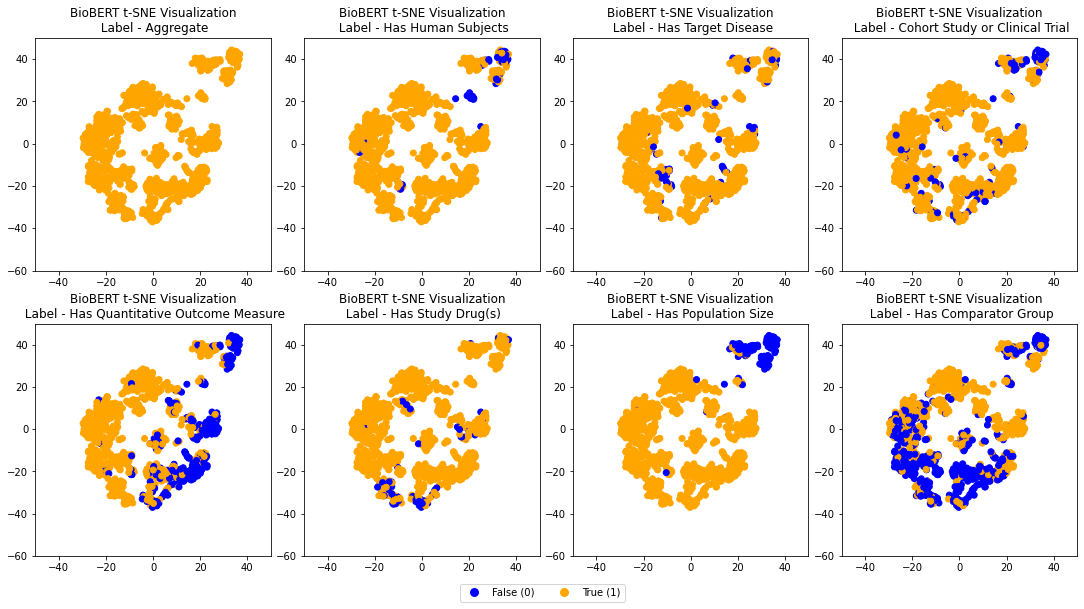

In [18]:
import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning) 

label_names = ["Aggregate",  # Ignore aggregate => i.e., useless... keeping for sake of being more presentable
               "Has Human Subjects",
               "Has Target Disease",
               "Cohort Study or Clinical Trial",
               "Has Quantitative Outcome Measure",
               "Has Study Drug(s)",
               "Has Population Size",
               "Has Comparator Group"]

fig, axs = plt.subplots(2, 4, figsize=(15, 8))

tsne = TSNE(n_components = 2, random_state = 128)
embedded = tsne.fit_transform(pooled_output)
labels_list = processed_dataset["test"]["label"]

for idx in range(len(label_names)):
    ax = axs.flatten()[idx]
    binary_rep = [label[idx] for label in labels_list]

    # Plot results 
    colors = ['blue' if label == 0 else 'orange' for label in binary_rep]
    ax.scatter(embedded[:, 0], embedded[:, 1], c = colors)
    ax.set_xlim([-50, 50]) # x-axis bounds
    ax.set_ylim([-60, 50]) # y-axis bounds
    ax.set_title(f'BioBERT t-SNE Visualization\n Label - {label_names[idx]}')

fig.tight_layout(pad = 0.5)
leg_labels = ['False (0)', 'True (1)']
leg_elements = [plt.Line2D([0], [0], marker = 'o', color = 'w', markerfacecolor = 'blue', markersize = 10),
                plt.Line2D([0], [0], marker = 'o', color = 'w', markerfacecolor = 'orange', markersize = 10)]
fig.legend(leg_elements, leg_labels, loc = 'lower center', ncol = 2, bbox_to_anchor=(0.5, -0.05))
plt.savefig('t_sne_label_attention_visualization.jpg', format = 'jpeg')

plt.show()


In [15]:
torch.tensor(labels_list).sum(0)

tensor([998., 939., 939., 888., 691., 932., 878., 530.])

In [16]:
embedded.shape

(998, 2)

In [17]:
print(processed_dataset["test"]['label'])

[[1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0], [1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0], [1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0], [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0], [1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0], [1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0], [1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.